In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
import seaborn as sns

Contains a database of all daily returns of stocks in the S&P 500 index from 2017

In [2]:
df_panel_filtered = pd.read_csv("Data/S&P_data_s.csv")
df_panel_filtered.head()

,date,Ticker,Return
0,2017-01-03,ORCL,0.006502
1,2017-01-04,ORCL,0.004929
2,2017-01-05,ORCL,-0.002581
3,2017-01-06,ORCL,-0.004917
4,2017-01-09,ORCL,0.015085


In [3]:
df = df_panel_filtered.pivot_table(
    index='date',
    columns='Ticker',
    values=['Return']
)
df.columns = [f"{col_name}_{stock_name}" for col_name, stock_name in df]
df.fillna(0, inplace=True)
df.head()

,Return_A,Return_AABA,Return_AAL,Return_AAP,Return_AAPL,Return_AAXN,Return_ABBV,Return_ABC,Return_ABMD,Return_ABNB,...,Return_XRX,Return_XYL,Return_YELL,Return_YHOO,Return_YRCW,Return_YUM,Return_ZBH,Return_ZBRA,Return_ZION,Return_ZTS
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.020413,0.0,-0.008353,0.008751,0.002849,0.0,-0.003354,0.056529,-0.002840,0.0,...,0.103551,0.002625,0.0,0.005948,0.019578,-0.001895,0.001260,0.005714,0.003253,0.001121
2017-01-04,0.013121,0.0,0.008639,0.008206,-0.001119,0.0,0.014100,0.024815,0.030082,0.0,...,0.037736,0.014904,0.0,0.029820,0.044313,0.003639,0.009194,0.009043,0.014358,0.009703
2017-01-05,-0.011890,0.0,-0.017345,-0.000698,0.005085,0.0,0.007584,-0.011576,-0.008035,0.0,...,-0.004196,-0.009129,0.0,0.031952,-0.020509,0.003310,0.006425,-0.026198,-0.016210,-0.003327
2017-01-06,0.031156,0.0,0.006973,-0.013091,0.011148,0.0,0.000314,0.013384,0.005313,0.0,...,-0.015449,-0.007010,0.0,-0.002661,-0.013718,0.012097,0.000095,0.014277,0.006498,0.003152
2017-01-09,0.003126,0.0,0.018827,-0.000590,0.009160,0.0,0.006584,0.008019,0.014642,0.0,...,-0.005706,-0.004236,0.0,0.002668,-0.024890,0.002794,0.019436,0.000116,-0.010837,-0.002773


Performing rolling PCA (Principal Component Analysis) on the data and calculating the number of principal components needed to explain at least 90% of the variance

In [5]:
#rolling PCA
window_size = 60
explained_var_matrix = []

for start in range(len(df) - window_size + 1):
    window_data = df.iloc[start:start+window_size]
    pca = PCA()
    pca.fit(window_data)
    explained_var_matrix.append(pca.explained_variance_ratio_)

explained_var_matrix = np.array(explained_var_matrix)

avg_explained_var = np.mean(explained_var_matrix, axis=0)
cumulative_var = np.cumsum(avg_explained_var)

optimal_moving_components = np.argmax(cumulative_var >= 0.90) + 1
print(f"The minimum number of components that explains at least 90% of the variance: {optimal_moving_components}")

The minimum number of components that explains at least 90% of the variance: 36


In [ ]:
window_size = window_size
rolling_pca_components = []
rolling_dates = []

for start in range(len(df) - window_size + 1):
    end = start + window_size
    window_data = df.iloc[start:end]

    # (optimal_components)
    pca = PCA(n_components=optimal_moving_components)
    components = pca.fit_transform(window_data)

    last_component = components[-1]
    rolling_pca_components.append(last_component)
    rolling_dates.append(df.index[end - 1])

pca_columns = [f'PC{i+1}' for i in range(optimal_moving_components)]
rolling_pca_df = pd.DataFrame(rolling_pca_components, columns=pca_columns)
rolling_pca_df['date'] = rolling_dates
rolling_pca_df['date'] = pd.to_datetime(rolling_pca_df['date'])
rolling_pca_df.set_index('date', inplace=True)

print("PCA DataFrame כולל סטיית תקן:")
rolling_pca_df.head()

PCA DataFrame כולל סטיית תקן:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
date,,,,,,,,,,,,,,,,,,,,,
2017-03-29,0.118992,0.164933,-0.030665,0.000227,-0.081004,-0.002407,0.035930,-0.080298,-0.114003,0.034764,...,-0.028189,0.004309,-0.053378,-0.039055,-0.037664,-0.041278,0.045349,0.059483,0.085489,0.020776
2017-03-30,0.104784,-0.086174,-0.007083,-0.082395,0.104161,-0.017188,-0.085186,-0.101615,0.054778,-0.040017,...,-0.053863,0.032132,-0.089070,-0.058561,-0.097054,0.013656,-0.048404,-0.059154,-0.090315,-0.073443
2017-03-31,-0.002228,0.051638,-0.070500,0.054390,-0.011394,-0.001567,0.030182,0.019585,-0.031568,-0.009524,...,0.002692,0.027918,0.041773,0.017650,-0.026472,-0.001182,-0.023810,0.024872,0.025606,-0.032301
2017-04-03,-0.176949,-0.018420,0.051859,0.016895,0.002111,-0.006891,0.000454,-0.032912,-0.012422,0.032979,...,-0.033703,0.022163,0.027633,0.044635,0.008400,-0.091289,-0.040063,0.049228,0.012702,-0.019278
2017-04-04,-0.021850,-0.047530,0.232296,0.056476,0.014690,0.006374,0.040716,0.010891,-0.134485,0.048709,...,0.002217,-0.044126,-0.122925,-0.094595,-0.049931,-0.051987,0.064637,0.053295,-0.048040,0.027517


Adding data on market volume, the Fear and Greed Index, and the Vix Index

In [7]:
df1 = pd.read_csv("Data/volume_vix_fng.csv")
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace=True)

factor = np.sqrt(36 / 3)
df1 = df1 * factor

df1.rename(columns={'Date': 'date'}, inplace=True)
df1_index = df1.index
df1_columns = df1.columns

scaler = StandardScaler()
df1 = scaler.fit_transform(df1)
standardized_df_wide1 = pd.DataFrame(df1, columns=df1_columns, index=df1_index)

merged_df = pd.concat([standardized_df_wide1, rolling_pca_df], axis=1, join='inner')
merged_df.head()

,Volume_SPY,VIX,fear_and_greed,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
2018-01-02,0.106882,-1.310097,0.698491,0.336065,0.180969,0.132866,0.144012,0.127599,0.043361,-0.116521,...,0.008339,-0.040130,-0.060247,-0.067254,-0.093173,0.049483,-0.088850,-0.099911,-0.037189,0.009014
2018-01-03,0.188854,-1.390521,0.895816,0.030087,0.183433,0.080445,0.032937,0.087095,-0.015285,-0.057506,...,-0.020251,0.139516,-0.018182,0.109673,-0.034643,-0.014195,0.086619,0.015616,0.009562,0.064875
2018-01-04,-0.037614,-1.381441,1.142471,0.033757,0.076695,0.029311,-0.052153,-0.010197,-0.065398,0.025988,...,-0.110571,0.150063,-0.033711,0.017705,0.057649,0.052379,0.055474,0.110610,0.004501,0.037573
2018-01-05,0.031704,-1.381441,1.290464,0.078042,0.022655,0.171565,0.270315,0.147781,0.084065,0.242591,...,0.021154,0.004889,-0.017802,-0.029029,0.060695,-0.007822,0.012726,-0.001706,-0.015894,-0.000798
2018-01-08,-0.597354,-1.342526,1.290464,0.026874,0.087003,0.066116,0.057998,0.008539,-0.016062,0.063215,...,-0.011138,0.023543,0.030426,-0.039620,0.020357,0.039533,-0.050979,0.094911,-0.105946,0.025201


Dividing the DataFrame to Training, Testing and Validation

In [8]:
train_df = merged_df[(merged_df.index >= '2018-01-01') & (merged_df.index <= '2020-12-31')]
test_df = merged_df[(merged_df.index >= '2021-01-01') & (merged_df.index <= '2022-12-31')]
validation_df = merged_df[(merged_df.index >= '2023-01-01') & (merged_df.index <= '2024-12-31')]

Finding the optimal number of groups/clusters for k-means and model training

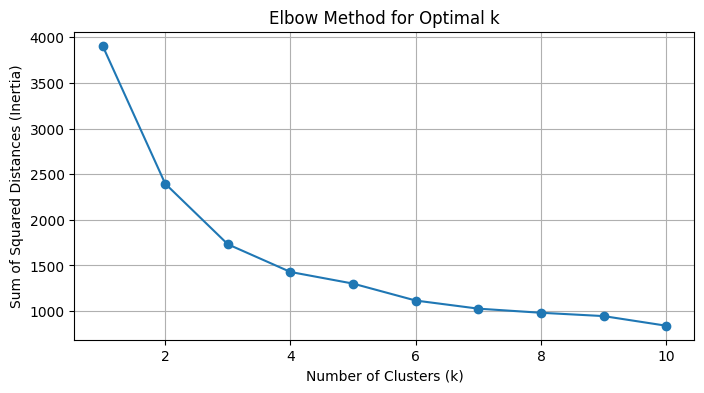

In [9]:
sse = []

k_range = list(range(1, 11))
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(train_df)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, marker='o')

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

We chose parameter 7 because up to it there was a significant improvement in accuracy.

In [10]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(train_df)
train_df['cluster'] = clusters

display(train_df['cluster'])

/var/folders/n2/5zs6svl55gx64b0r2s5n0yn80000gn/T/ipykernel_54624/4000225190.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cluster'] = clusters


2018-01-02    5
2018-01-03    0
2018-01-04    0
2018-01-05    0
2018-01-08    0
             ..
2020-12-24    4
2020-12-28    4
2020-12-29    4
2020-12-30    4
2020-12-31    4
Name: cluster, Length: 756, dtype: int32

This file contains a pair of stocks that have a correlation in the chip sector.

In [ ]:
amd_nvda_df = pd.read_csv("Data/AmdNvda.csv")
if 'date' in amd_nvda_df.columns:
    amd_nvda_df['date'] = pd.to_datetime(amd_nvda_df['date'])
    amd_nvda_df.set_index('date', inplace=True)
work_df = pd.merge(amd_nvda_df, train_df['cluster'], left_index=True, right_index=True, how='inner')
work_df.head()

,Return_AMD,Volume_AMD,Close_AMD,Spread_AMD,Return_NVDA,Volume_NVDA,Close_NVDA,Spread_NVDA,cluster
2018-01-02,0.068093,44146332.0,10.98,0.68,0.030233,8890417.0,4.98375,0.12500,5
2018-01-03,0.051913,154144861.0,11.55,0.78,0.065814,22868175.0,5.31175,0.24875,0
2018-01-04,0.049351,109502970.0,12.12,0.46,0.005271,14581867.0,5.33975,0.13400,0
2018-01-05,-0.019802,63808946.0,11.88,0.56,0.008474,14503113.0,5.38500,0.14575,0
2018-01-08,0.033670,63346034.0,12.28,0.45,0.030641,22032519.0,5.55000,0.16050,0


In [12]:
work_df['cluster'].value_counts()

cluster
5    208
0    162
2    133
4    123
1     55
6     49
3     26
Name: count, dtype: int64

Simple Price-Based Pairs Trading Strategy For Global Optimization of Parameters

In [13]:
def generic_strategy(data, params, price_col_1='Close_AMD', price_col_2='Close_NVDA'):

    if params is None:
        data['strategy_return'] = np.nan
        return data

    entry_threshold = params['entry_threshold']
    exit_threshold = params['exit_threshold']

    df = data.copy()
    df[price_col_1] = pd.to_numeric(df[price_col_1], errors='coerce')
    df[price_col_2] = pd.to_numeric(df[price_col_2], errors='coerce')
    df.dropna(subset=[price_col_1, price_col_2], inplace=True)

    hedge_ratio = np.polyfit(df[price_col_2], df[price_col_1], 1)[0]
    df['Spread'] = df[price_col_1] - hedge_ratio * df[price_col_2]
    spread_mean = df['Spread'].mean()
    spread_std = df['Spread'].std()
    df['Z-Score'] = (df['Spread'] - spread_mean) / spread_std

    position = 0
    positions = []
    for z in df['Z-Score']:
        if position == 0:
            if z < -entry_threshold:
                position = 1
            elif z > entry_threshold:
                position = -1
        elif abs(z) < exit_threshold:
            position = 0
        positions.append(position)
    df['position'] = positions

    df['ret1'] = df[price_col_1].pct_change()
    df['ret2'] = df[price_col_2].pct_change()
    df['strategy_return'] = df['position'].shift(1) * (df['ret1'] - hedge_ratio * df['ret2'])

    return df


def total_return(returns):

    return (1 + returns).prod() - 1


# Global Parameter Optimization
def optimize_parameters(data, strategy_func, param_grid, metric_func, return_col='strategy_return'):

    best_score = -np.inf
    best_params = None

    for params in param_grid:
        result = strategy_func(data, params)
        score = metric_func(result[return_col].dropna())
        if score > best_score:
            best_score = score
            best_params = params

    return best_params


# Optimization per Cluster
def optimize_by_cluster(df, strategy_func, param_grid, metric_func,
                        cluster_col='cluster', return_col='strategy_return'):

    cluster_params = {}
    for cluster_id in df[cluster_col].unique():
        cluster_data = df[df[cluster_col] == cluster_id]
        best_params = optimize_parameters(cluster_data, strategy_func, param_grid, metric_func, return_col)
        cluster_params[cluster_id] = best_params
    return cluster_params


def run_strategy_with_clusters(df, strategy_func, cluster_params,
                               return_col='strategy_return', cluster_col='cluster'):

    df = df.copy()
    all_results = []

    for cluster_id, params in cluster_params.items():
        cluster_data = df[df[cluster_col] == cluster_id]
        if cluster_data.empty or params is None:
            continue
        result = strategy_func(cluster_data, params)
        result = result[[return_col]]
        all_results.append(result)

    merged = pd.concat(all_results)
    df[return_col] = merged.sort_index()[return_col]
    return df



def analyze_and_plot(df, cluster_params, global_params,
                     return_col_clustered='strategy_return',
                     return_col_all='return_all',
                     price_col='Close_AMD', cluster_col='cluster'):

    df = df.copy()

    df['buy_hold'] = df[price_col].pct_change()
    df['buy_hold_cum'] = (1 + df['buy_hold'].fillna(0)).cumprod()
    df['strategy_all_cum'] = (1 + df[return_col_all].fillna(0)).cumprod()
    df['strategy_clustered_cum'] = (1 + df[return_col_clustered].fillna(0)).cumprod()

    def compute_stats(returns, label, params=None):
        ret = returns.dropna()
        cum_return = (1 + ret).prod() - 1
        daily_std = ret.std()
        sharpe = (ret.mean() / daily_std) * np.sqrt(252) if daily_std > 0 else np.nan
        num_trades = (ret != 0).sum()
        avg_trade = ret[ret != 0].mean() * 100 if num_trades > 0 else 0
        win_rate = (ret[ret > 0].count() / num_trades) * 100 if num_trades > 0 else np.nan

        return {
            'Strategy': label,
            'Total Return (%)': cum_return * 100,
            'Avg Return per Trade (%)': avg_trade,
            'Win Rate (%)': win_rate,
            'Number of Trades': num_trades,
            'Daily Std (%)': daily_std * 100,
            'Sharpe Ratio': sharpe,
            'Days': len(returns),
            'Entry Threshold': params.get('entry_threshold') if params else np.nan,
            'Exit Threshold': params.get('exit_threshold') if params else np.nan
        }

    stats_summary = [
        compute_stats(df['buy_hold'], 'Buy & Hold'),
        compute_stats(df[return_col_all], 'Global Strategy', global_params),
        compute_stats(df[return_col_clustered], 'Clustered Strategy')
    ]

    summary_df = pd.DataFrame(stats_summary)
    print("\n📊 Summary of All Strategies:")
    print(summary_df.to_string(index=False))

    cluster_stats = []
    for cluster_id in sorted(df[cluster_col].dropna().unique()):
        cluster_data = df[df[cluster_col] == cluster_id].copy()
        cluster_ret = cluster_data[return_col_clustered]
        params = cluster_params.get(cluster_id, {})
        stat = compute_stats(cluster_ret, f'Cluster {cluster_id}', params)
        stat['Cluster'] = cluster_id
        cluster_stats.append(stat)

    cluster_df = pd.DataFrame(cluster_stats).sort_values('Cluster')
    print("\n📌 Cluster-Level Breakdown:")
    print(cluster_df.drop(columns=['Strategy']).to_string(index=False))

    import matplotlib.colors as mcolors
    unique_clusters = sorted(df[cluster_col].dropna().unique())
    base_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    cluster_color_map = {cluster: base_colors[i % len(base_colors)] for i, cluster in enumerate(unique_clusters)}

    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['buy_hold_cum'], label='Buy & Hold', color='gray', linewidth=1.5)
    plt.plot(df.index, df['strategy_all_cum'], label='Global Strategy', color='blue', linewidth=1.5)
    plt.plot(df.index, df['strategy_clustered_cum'], label='Clustered Strategy', color='green', linewidth=1.5)

    current_cluster = None
    start_idx = 0
    legend_shown = set()

    for i in range(len(df)):
        cluster = df[cluster_col].iloc[i]
        if cluster != current_cluster:
            if current_cluster is not None:
                color = cluster_color_map[current_cluster]
                label = f'Cluster {current_cluster}' if current_cluster not in legend_shown else None
                plt.axvspan(df.index[start_idx], df.index[i - 1], color=color, alpha=0.08, label=label)
                legend_shown.add(current_cluster)
            current_cluster = cluster
            start_idx = i
    if current_cluster is not None:
        color = cluster_color_map[current_cluster]
        label = f'Cluster {current_cluster}' if current_cluster not in legend_shown else None
        plt.axvspan(df.index[start_idx], df.index[-1], color=color, alpha=0.08, label=label)

    plt.title("Cumulative Returns: Buy & Hold vs Global vs Clustered")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return summary_df, cluster_df

def get_cluster_params_df(cluster_params):

    data = []
    for cluster, params in cluster_params.items():
        if params is not None:
            entry = params.get('entry_threshold', np.nan)
            exit_ = params.get('exit_threshold', np.nan)
        else:
            entry, exit_ = np.nan, np.nan
        data.append({
            'Cluster': cluster,
            'Entry Threshold': entry,
            'Exit Threshold': exit_
        })

    return pd.DataFrame(data).sort_values(by='Cluster').reset_index(drop=True)

Entry_Threshold and Exit_Threshold Optimization


📊 Summary of All Strategies:
          Strategy  Total Return (%)  Avg Return per Trade (%)  Win Rate (%)  Number of Trades  Daily Std (%)  Sharpe Ratio  Days  Entry Threshold  Exit Threshold
        Buy & Hold        735.245902                  0.352440     52.996005               751       3.736583      1.489373   756              NaN             NaN
   Global Strategy          0.000000                  0.000000           NaN                 0       0.000000           NaN   756              2.0             0.1
Clustered Strategy      11991.316002                  5.244313     54.227405               343      30.560917      1.247484   756              NaN             NaN

📌 Cluster-Level Breakdown:
 Total Return (%)  Avg Return per Trade (%)  Win Rate (%)  Number of Trades  Daily Std (%)  Sharpe Ratio  Days  Entry Threshold  Exit Threshold  Cluster
      2502.638960                  7.421256     53.956835               139      55.348321      1.837647   162              0.5          

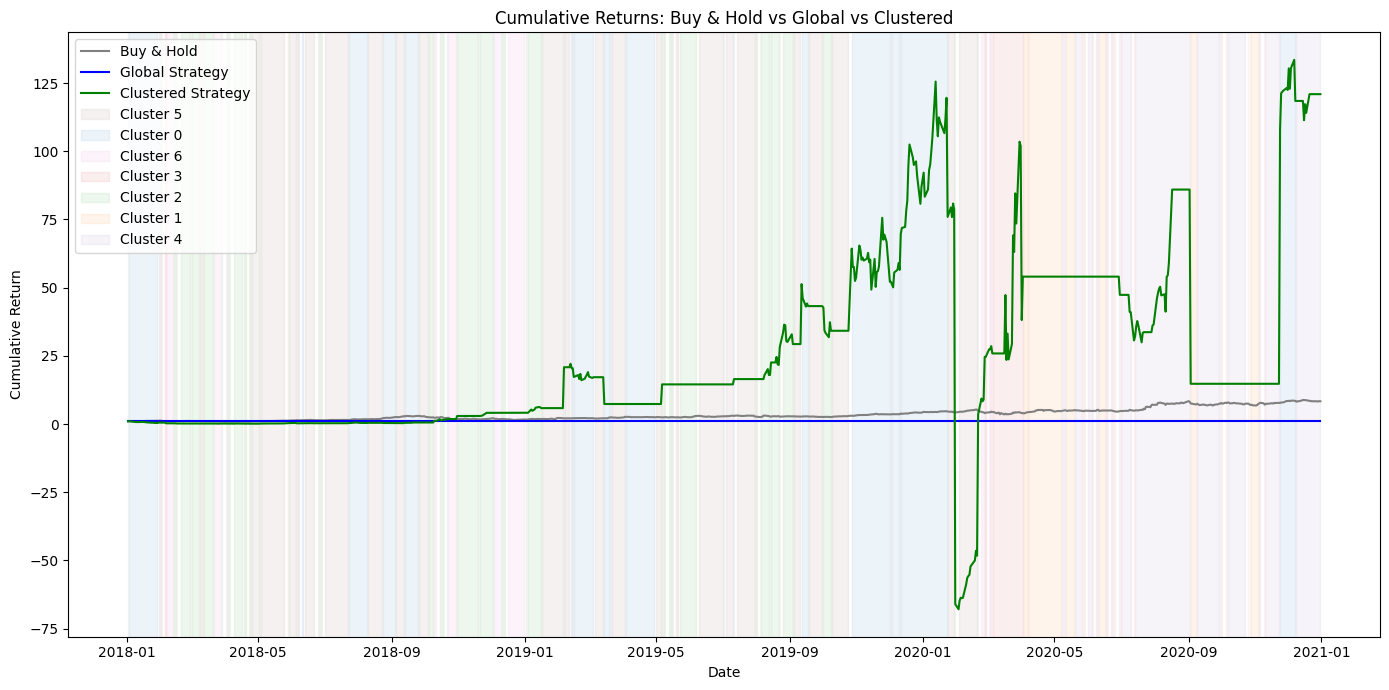

{np.int32(5): {'entry_threshold': np.float64(1.0), 'exit_threshold': np.float64(0.6)}, np.int32(0): {'entry_threshold': np.float64(0.5), 'exit_threshold': np.float64(0.1)}, np.int32(6): {'entry_threshold': np.float64(1.0), 'exit_threshold': np.float64(0.1)}, np.int32(3): {'entry_threshold': np.float64(0.5), 'exit_threshold': np.float64(0.1)}, np.int32(2): {'entry_threshold': np.float64(1.0), 'exit_threshold': np.float64(0.6)}, np.int32(1): {'entry_threshold': np.float64(2.0), 'exit_threshold': np.float64(1.1)}, np.int32(4): {'entry_threshold': np.float64(1.5), 'exit_threshold': np.float64(1.1)}}
   Cluster  Entry Threshold  Exit Threshold
0        0              0.5             0.1
1        1              2.0             1.1
2        2              1.0             0.6
3        3              0.5             0.1
4        4              1.5             1.1
5        5              1.0             0.6
6        6              1.0             0.1


In [14]:
param_grid = [
    {'entry_threshold': e, 'exit_threshold': x}
    for e in np.arange(0.5, 2.1, 0.5)
    for x in np.arange(0.1, 1.5, 0.5)
    if x < e
]

# Step 1 – General Optimization
global_params = optimize_parameters(
    work_df,
    strategy_func=generic_strategy,
    param_grid=param_grid,
    metric_func=total_return
)
work_df = generic_strategy(work_df, global_params)
work_df['return_all'] = work_df['strategy_return']

# Step 2 – Optimization by clusters
cluster_params = optimize_by_cluster(
    work_df,
    strategy_func=generic_strategy,
    param_grid=param_grid,
    metric_func=total_return,
    cluster_col='cluster',
    return_col='strategy_return'
)
work_df = run_strategy_with_clusters(
    work_df,
    strategy_func=generic_strategy,
    cluster_params=cluster_params,
    return_col='strategy_return',
    cluster_col='cluster'
)

# Step 3 – Comparison graph
summary_df, cluster_df = analyze_and_plot(
    df=work_df,
    cluster_params=cluster_params,
    global_params=global_params,
    return_col_clustered='strategy_return',
    return_col_all='return_all',
    price_col='Close_AMD',
    cluster_col='cluster'
)


print(cluster_params)
cluster_params_df = get_cluster_params_df(cluster_params)

print(cluster_params_df)

Saving optimal parameters for trading pairs according to each cluster

In [16]:
entry_0 = cluster_params_df.loc[cluster_params_df['Cluster'] == 0, 'Entry Threshold'].values[0]
exit_0 = cluster_params_df.loc[cluster_params_df['Cluster'] == 0, 'Exit Threshold'].values[0]
entry_1 = cluster_params_df.loc[cluster_params_df['Cluster'] == 1, 'Entry Threshold'].values[0]
exit_1 = cluster_params_df.loc[cluster_params_df['Cluster'] == 1, 'Exit Threshold'].values[0]
entry_2 = cluster_params_df.loc[cluster_params_df['Cluster'] == 2, 'Entry Threshold'].values[0]
exit_2 = cluster_params_df.loc[cluster_params_df['Cluster'] == 2, 'Exit Threshold'].values[0]
entry_3 = cluster_params_df.loc[cluster_params_df['Cluster'] == 3, 'Entry Threshold'].values[0]
exit_3 = cluster_params_df.loc[cluster_params_df['Cluster'] == 3, 'Exit Threshold'].values[0]
entry_4 = cluster_params_df.loc[cluster_params_df['Cluster'] == 4, 'Entry Threshold'].values[0]
exit_4 = cluster_params_df.loc[cluster_params_df['Cluster'] == 4, 'Exit Threshold'].values[0]
entry_5 = cluster_params_df.loc[cluster_params_df['Cluster'] == 5, 'Entry Threshold'].values[0]
exit_5 = cluster_params_df.loc[cluster_params_df['Cluster'] == 5, 'Exit Threshold'].values[0]
entry_6 = cluster_params_df.loc[cluster_params_df['Cluster'] == 6, 'Entry Threshold'].values[0]
exit_6 = cluster_params_df.loc[cluster_params_df['Cluster'] == 6, 'Exit Threshold'].values[0]

A pairs trading strategy that takes into account representative parameters for each cluster

In [17]:
def cluster_based_pair_strategy(work_df, close_1, close_2,
         entry_0, exit_0,
         entry_1, exit_1,
         entry_2, exit_2,
         entry_3, exit_3,
         entry_4, exit_4,
         entry_5, exit_5,
         entry_6, exit_6):

    df = work_df[[close_1, close_2, 'cluster']].copy()
    df = df.sort_index()
    df['cluster'] = df['cluster'].astype(int)
    df['Return_1'] = df[close_1].pct_change()
    df['Return_2'] = df[close_2].pct_change()
    df = df.dropna()


    entry_thresholds = {
        0: entry_0, 1: entry_1, 2: entry_2,
        3: entry_3, 4: entry_4, 5: entry_5, 6: entry_6
    }
    exit_thresholds = {
        0: exit_0, 1: exit_1, 2: exit_2,
        3: exit_3, 4: exit_4, 5: exit_5, 6: exit_6
    }

    cluster_returns = {}
    position = 0
    entry_r1, entry_r2 = None, None
    current_cluster = None
    hedge_ratio = None
    spread_mean = None
    spread_std = None
    trade_count = {}
    pnl_total = {}

    for i in range(1, len(df)):
        cluster = df.iloc[i]['cluster']

        if current_cluster != cluster:
            if position != 0:
                r1 = df.iloc[i]['Return_1']
                r2 = df.iloc[i]['Return_2']
                if position == 1:
                    pnl = (r1 - entry_r1) - hedge_ratio * (r2 - entry_r2)
                else:
                    pnl = (entry_r1 - r1) - hedge_ratio * (entry_r2 - r2)
                pnl_total[current_cluster] += pnl
                trade_count[current_cluster] += 1
                position = 0

            cluster_data = df[df['cluster'] == cluster].dropna()
            if len(cluster_data) < 30:
                continue

            X = cluster_data['Return_2']
            y = cluster_data['Return_1']
            hedge_ratio = np.polyfit(X, y, 1)[0]
            spread = y - hedge_ratio * X
            spread_mean = spread.mean()
            spread_std = spread.std()

            if cluster not in pnl_total:
                pnl_total[cluster] = 0
                trade_count[cluster] = 0

            current_cluster = cluster

        entry_threshold = entry_thresholds.get(cluster, 1.0)
        exit_threshold = exit_thresholds.get(cluster, 0.2)

        z = ((df.iloc[i]['Return_1'] - hedge_ratio * df.iloc[i]['Return_2']) - spread_mean) / spread_std

        if position == 0:
            if z < -entry_threshold:
                position = 1
                entry_r1 = df.iloc[i]['Return_1']
                entry_r2 = df.iloc[i]['Return_2']
            elif z > entry_threshold:
                position = -1
                entry_r1 = df.iloc[i]['Return_1']
                entry_r2 = df.iloc[i]['Return_2']

        elif abs(z) < exit_threshold:
            r1 = df.iloc[i]['Return_1']
            r2 = df.iloc[i]['Return_2']
            if position == 1:
                pnl = (r1 - entry_r1) - hedge_ratio * (r2 - entry_r2)
            else:
                pnl = (entry_r1 - r1) - hedge_ratio * (entry_r2 - r2)
            pnl_total[current_cluster] += pnl
            trade_count[current_cluster] += 1
            position = 0


    for cluster in sorted(pnl_total.keys()):
        total = pnl_total[cluster] * 100
        trades = trade_count[cluster]
        avg = total / trades if trades > 0 else 0
        print(f"Cluster {cluster}: Total Return = {total:.2f}%, Trades = {trades}, Avg Return/Trade = {avg:.4f}%")

    results = []
    for cluster in sorted(pnl_total.keys()):
        total = pnl_total[cluster] * 100
        trades = trade_count[cluster]
        avg = total / trades if trades > 0 else 0
        results.append({'cluster': cluster, 'pairStrategyPerTrade': avg})

    return pd.DataFrame(results)

Pairs trading strategy without considering clusters - For comparison purposes

In [18]:
def pair_simple(work_df, close_1, close_2, entry_threshold=1.0, exit_threshold=0.2):
    columns_to_keep = [close_1, close_2]
    df = work_df[columns_to_keep].copy()
    df = df.sort_index()

    # Calculate daily returns
    df['Return_1'] = df[close_1].pct_change()
    df['Return_2'] = df[close_2].pct_change()
    df = df.dropna()

    if len(df) < 30:
        print(f"{close_1} / {close_2} - Not enough data")
        return

    X = df['Return_2']
    y = df['Return_1']
    hedge_ratio = np.polyfit(X, y, 1)[0]
    spread = y - hedge_ratio * X
    spread_std = spread.std()
    spread_mean = spread.mean()
    df['Z-Score'] = (spread - spread_mean) / spread_std

    position = 0
    entry_r1, entry_r2 = None, None
    pnl_total = 0
    trade_count = 0 

    for i in range(len(df)):
        row = df.iloc[i]
        z = row['Z-Score']
        r1 = row['Return_1']
        r2 = row['Return_2']

        if position == 0:
            if z < -entry_threshold:
                position = 1  # Long  1
                entry_r1, entry_r2 = r1, r2
            elif z > entry_threshold:
                position = -1  # Short  1
                entry_r1, entry_r2 = r1, r2

        elif abs(z) < exit_threshold:
            if position == 1:
                pnl = (r1 - entry_r1) - hedge_ratio * (r2 - entry_r2)
                pnl_total += pnl
                trade_count += 1
                position = 0
            elif position == -1:
                pnl = (entry_r1 - r1) - hedge_ratio * (entry_r2 - r2)
                pnl_total += pnl
                trade_count += 1
                position = 0

    avg_return = (pnl_total * 100 / trade_count) if trade_count > 0 else 0

    print(f"{close_1} / {close_2} | Total Return: {pnl_total * 100:.2f}%, Trades: {trade_count}, Avg Return/Trade: {avg_return:.4f}%")

Implementing the strategies - with and without considering clusters

In [23]:
pair_results = {}
pair_list = [
    ("Close_AMD", "Close_NVDA"),
]

for a, b in pair_list:
    print(f"▶️ {a} / {b}")
    pair_simple(work_df, a, b)

    result_df = cluster_based_pair_strategy(
        work_df, a, b,
        entry_0, exit_0,
        entry_1, exit_1,
        entry_2, exit_2,
        entry_3, exit_3,
        entry_4, exit_4,
        entry_5, exit_5,
        entry_6, exit_6
    )

    key = f"{a}_{b}"
    pair_results[key] = result_df

▶️ Close_AMD / Close_NVDA
Close_AMD / Close_NVDA | Total Return: 362.95%, Trades: 76, Avg Return/Trade: 4.7757%
Cluster 0.0: Total Return = 81.99%, Trades = 25, Avg Return/Trade = 3.2797%
Cluster 1.0: Total Return = 8.46%, Trades = 2, Avg Return/Trade = 4.2290%
Cluster 2.0: Total Return = 118.23%, Trades = 22, Avg Return/Trade = 5.3739%
Cluster 4.0: Total Return = 79.90%, Trades = 10, Avg Return/Trade = 7.9903%
Cluster 5.0: Total Return = 193.96%, Trades = 38, Avg Return/Trade = 5.1043%
Cluster 6.0: Total Return = 41.42%, Trades = 9, Avg Return/Trade = 4.6026%


Momentum strategy - without considering clusters

In [24]:
import matplotlib.pyplot as plt

def ema_strategy(df, close_col, ema_short, ema_long):
    df = df.copy()
    df['EMA_short'] = df[close_col].ewm(span=ema_short, adjust=False).mean()
    df['EMA_long'] = df[close_col].ewm(span=ema_long, adjust=False).mean()

    df['prev_ema_short'] = df['EMA_short'].shift(1)
    df['prev_ema_long'] = df['EMA_long'].shift(1)

    df['position_change'] = 0
    df.loc[
        (df['prev_ema_short'] < df['prev_ema_long']) &
        (df['EMA_short'] > df['EMA_long']), 'position_change'] = 1  # BUY
    df.loc[
        (df['prev_ema_short'] > df['prev_ema_long']) &
        (df['EMA_short'] < df['EMA_long']), 'position_change'] = -1  # SELL

    trades = []
    position = None
    entry_price = None
    entry_index = None
    trade_dates = []

    for i, row in df.iterrows():
        signal = row['position_change']
        price = row[close_col]

        if signal == 1:
            if position == 'short':
                profit = (entry_price - price) / entry_price
                trades.append(profit)
                trade_dates.append((entry_index, i, 'SELL→BUY'))
                position = None
            if position is None:
                entry_price = price
                entry_index = i
                position = 'long'

        elif signal == -1:
            if position == 'long':
                profit = (price - entry_price) / entry_price
                trades.append(profit)
                trade_dates.append((entry_index, i, 'BUY→SELL'))
                position = None
            if position is None:
                entry_price = price
                entry_index = i
                position = 'short'

    if position is not None and entry_price is not None:
        final_price = df[close_col].iloc[-1]
        final_index = df.index[-1]
        if position == 'long':
            profit = (final_price - entry_price) / entry_price
            trade_dates.append((entry_index, final_index, 'BUY→SELL'))
        else:
            profit = (entry_price - final_price) / entry_price
            trade_dates.append((entry_index, final_index, 'SELL→BUY'))
        trades.append(profit)


    total_return = sum(trades)
    num_trades = len(trades)
    return_per_trade = total_return / num_trades if num_trades > 0 else 0
    stock_name = close_col.replace('Close_', '')

    plt.figure(figsize=(9, 3))
    plt.plot(df[close_col], label='Close Price', alpha=0.5)
    plt.plot(df['EMA_short'], label=f'{ema_short}-Day EMA', color='green')
    plt.plot(df['EMA_long'], label=f'{ema_long}-Day EMA', color='red')

    for entry, exit, label in trade_dates:
        entry_price = df.loc[entry, close_col]
        plt.plot(entry, entry_price, '^' if 'BUY' in label else 'v',
                 color='green' if 'BUY' in label else 'red', markersize=10)
        plt.text(entry, entry_price * (0.98 if 'BUY' in label else 1.02),
                 label.split('→')[0], color='green' if 'BUY' in label else 'red',
                 fontsize=8, ha='center')

        exit_price = df.loc[exit, close_col]
        plt.plot(exit, exit_price, 'v' if 'SELL' in label else '^',
                 color='red' if 'SELL' in label else 'green', markersize=10)
        plt.text(exit, exit_price * (1.02 if 'SELL' in label else 0.98),
                 label.split('→')[1], color='red' if 'SELL' in label else 'green',
                 fontsize=8, ha='center')

    plt.title(f'EMA Strategy: EMA{ema_short}/{ema_long} | {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nStock: {stock_name} (Without Clusters)")
    print(f"Short_Window: {ema_short}  |  Long_Window: {ema_long}")
    print(f"Total Return: {round(total_return * 100, 2)}%")
    print(f"Number of Trades: {num_trades}")
    print(f"Average Return per Trade: {round(return_per_trade * 100, 2)}%\n")

    return stock_name, round(total_return, 4), num_trades, round(return_per_trade, 4)

Momentum Strategy - Considering Clusters

In [25]:
def ema_strategy_with_clusters(df, close_col, ema_short, ema_long):
    stock_name = close_col.replace('Close_', '')
    results = []

    print(f"\nStock: {stock_name} (With Clusters)")
    print(f"EMA Strategy: Short Window = {ema_short}, Long Window = {ema_long}")
    print("Results per Cluster:")

    for cluster_id in sorted(df['cluster'].unique()):
        cluster_df = df[df['cluster'] == cluster_id].copy()

        if len(cluster_df) < ema_long + 1:
            avg_return = 0.0
            num_trades = 0
            total_return = 0.0
        else:
            cluster_df['EMA_short'] = cluster_df[close_col].ewm(span=ema_short, adjust=False).mean()
            cluster_df['EMA_long'] = cluster_df[close_col].ewm(span=ema_long, adjust=False).mean()
            cluster_df['prev_ema_short'] = cluster_df['EMA_short'].shift(1)
            cluster_df['prev_ema_long'] = cluster_df['EMA_long'].shift(1)

            cluster_df['position_change'] = 0
            cluster_df.loc[
                (cluster_df['prev_ema_short'] < cluster_df['prev_ema_long']) &
                (cluster_df['EMA_short'] > cluster_df['EMA_long']),
                'position_change'] = 1  # BUY
            cluster_df.loc[
                (cluster_df['prev_ema_short'] > cluster_df['prev_ema_long']) &
                (cluster_df['EMA_short'] < cluster_df['EMA_long']),
                'position_change'] = -1  # SELL

            trades = []
            position = None
            entry_price = None

            for i, row in cluster_df.iterrows():
                signal = row['position_change']
                price = row[close_col]

                if signal == 1:  # BUY
                    if position == 'short':
                        trades.append((entry_price - price) / entry_price)
                        position = None
                    if position is None:
                        entry_price = price
                        position = 'long'

                elif signal == -1:  # SELL
                    if position == 'long':
                        trades.append((price - entry_price) / entry_price)
                        position = None
                    if position is None:
                        entry_price = price
                        position = 'short'

            if position is not None and entry_price is not None:
                final_price = cluster_df[close_col].iloc[-1]
                if position == 'long':
                    trades.append((final_price - entry_price) / entry_price)
                else:
                    trades.append((entry_price - final_price) / entry_price)

            total_return = sum(trades)
            num_trades = len(trades)
            avg_return = total_return / num_trades if num_trades > 0 else 0.0


        results.append({
            'cluster': cluster_id,
            'MomentumPerTrade': round(avg_return * 100, 4) 
        })

        print(f"  Cluster {cluster_id}: Total Return = {total_return*100:.2f}%, Trades = {num_trades}, Avg Return = {avg_return*100:.2f}%")

    return pd.DataFrame(results)

Implementing the strategies - with and without considering clusters

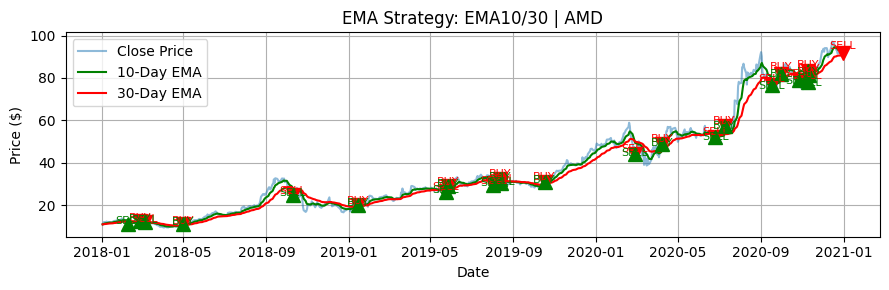


Stock: AMD (Without Clusters)
Short_Window: 10  |  Long_Window: 30
Total Return: 185.27%
Number of Trades: 22
Average Return per Trade: 8.42%


Stock: AMD (With Clusters)
EMA Strategy: Short Window = 10, Long Window = 30
Results per Cluster:
  Cluster 0: Total Return = 215.39%, Trades = 2, Avg Return = 107.69%
  Cluster 1: Total Return = 0.00%, Trades = 0, Avg Return = 0.00%
  Cluster 2: Total Return = 3.56%, Trades = 4, Avg Return = 0.89%
  Cluster 3: Total Return = 0.00%, Trades = 0, Avg Return = 0.00%
  Cluster 4: Total Return = 11.52%, Trades = 6, Avg Return = 1.92%
  Cluster 5: Total Return = 139.29%, Trades = 6, Avg Return = 23.21%
  Cluster 6: Total Return = 92.44%, Trades = 1, Avg Return = 92.44%


In [26]:
results = ema_strategy(work_df, 'Close_AMD', 10, 30)
result = ema_strategy_with_clusters(work_df, 'Close_AMD', 10, 30)

Testing